# Questão 2

<b>Alunos:</b>

<b>- Tacio Neri</b>

<b>- Camilla Rocha</b>

In [1]:
import operator
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dados = pd.read_csv('carbon_nanotubes.csv', usecols=[0,2,5], sep=';', decimal=',')
dados.head()

,Chiral indice n,Initial atomic coordinate u,Calculated atomic coordinates u'
0,2,0.679005,0.721039
1,2,0.717298,0.738414
2,2,0.489336,0.477676
3,2,0.413957,0.408823
4,2,0.334292,0.303349


In [3]:
x = list(dados.values[:,0])
z = list(dados.values[:,1])
saida = list(dados.values[:,2])

In [4]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 2)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1,1))
pset.renameArguments(ARG0='x')
pset.renameArguments(ARG1='z')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [6]:
def evalSymbReg(individual, x, z, saida):
    
    func = toolbox.compile(expr=individual)
    
    sqerrors = []
    
    
    for i in range(len(x)):
        sqerrors.append((func(x[i], z[i]) - saida[i])**2)
        
    return math.fsum(sqerrors) / len(x),

In [7]:
toolbox.register("evaluate", evalSymbReg, x=x, z=z, saida=saida)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [8]:
def main():
    random.seed(300)

    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, 0.75, 0.5, 100, stats=mstats,
                                   halloffame=hof, verbose=False)
    
    return pop, log, hof

In [9]:
def plot(function):        
              
        points = []
        
        for i in range(len(x)):
            points.append(function(x[i], z[i]))    
                
        fig1 = plt.figure()
        ax1 = fig1.gca(projection='3d')
        ax1.plot(x, z, saida, color='b')
        ax1.set_xlabel('Chiral indice n')
        ax1.set_ylabel('Initial atomic coordinate u')
        ax1.set_zlabel('Calculated atomic coordinate u')
        ax1.set_title('Função original')
        
        fig2 = plt.figure()
        ax2 = fig2.gca(projection='3d')
        ax2.plot(x, z, points, color='r') 
        ax2.set_xlabel('Chiral indice n')
        ax2.set_ylabel('Initial atomic coordinate u')
        ax2.set_zlabel('Calculated atomic coordinate u')       
        ax2.set_title('Função calculada')
        
        plt.show()

C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Camilla\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


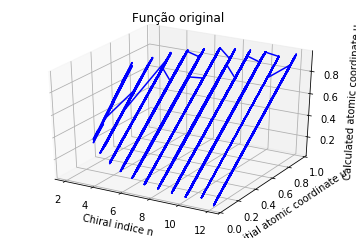

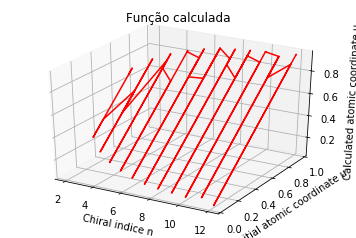

Função: add(mul(neg(sub(sub(add(sub(neg(sub(protectedDiv(add(add(sub(add(0.9856117753391114, x), neg(z)), protectedDiv(neg(sub(0.3681150753681326, z)), z)), neg(z)), 0.7316289704658818), neg(x))), add(neg(mul(neg(protectedDiv(x, z)), z)), x)), sub(-0.47009350567303576, z)), sub(add(z, x), protectedDiv(add(mul(sub(z, x), mul(x, z)), x), add(sub(-0.41501167608596146, z), mul(sub(z, x), mul(z, -0.4666514899959633)))))), protectedDiv(protectedDiv(-0.06086646808403584, x), neg(z)))), sub(z, z)), z)


In [10]:
if __name__ == "__main__":
    results = main()
    
    expr = results[2][0]
    
        
    tree = gp.PrimitiveTree(expr)
    
    function = toolbox.compile(tree)
    
    plot(function)
    
    print('Função: ' + str(expr))